# **Part 1**: Product Metrics & Behavioral Analysis

In [ ]:
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Data ---
users = pd.read_csv("data/users.csv")             # user_id, signup_date, channel, region
sessions = pd.read_csv("data/sessions.csv")       # session_id, user_id, start_time, end_time, device_type
feature_usage = pd.read_csv("data/feature_usage.csv")   # session_id, feature_name, usage_timestamp
feedback = pd.read_csv("data/feedback.csv")       # feedback_id, user_id, rating, feature_name, comments, session_id

# Preview
print("Users\n", users.head(), "\n")
print("Sessions\n", sessions.head(), "\n")
print("Feature Usage\n", feature_usage.head(), "\n")
print("Feedback\n", feedback.head(), "\n")


Users
   user_id signup_date   channel region
0    U101  2025-08-15   Organic  North
1    U102  2025-08-18      Paid  South
2    U103  2025-08-20  Referral   West
3    U104  2025-08-22   Organic  North
4    U105  2025-08-25      Paid   East 

Sessions
   session_id user_id           start_time             end_time device_type
0       S001    U111   2025-09-01 9:00:00   2025-09-01 9:15:00      Mobile
1       S002    U112  2025-09-01 10:05:00  2025-09-01 10:20:00     Desktop
2       S003    U101  2025-09-01 11:30:00  2025-09-01 11:40:00     Desktop
3       S004    U102  2025-09-01 14:00:00  2025-09-01 14:10:00      Mobile
4       S005    U104  2025-09-01 15:10:00  2025-09-01 15:30:00     Desktop 

Feature Usage
   session_id   feature_name      usage_timestamp
0       S001  CreateAccount   2025-09-01 9:05:00
1       S001  SearchCatalog   2025-09-01 9:10:00
2       S002  CreateAccount  2025-09-01 10:10:00
3       S003  SearchCatalog  2025-09-01 11:35:00
4       S004  SearchCatalog  2025-0

1. Daily & Weekly Active Users (DAU & WAU)

Daily Active Users:
           date  DAU
0   2025-09-01    6
1   2025-09-02    5
2   2025-09-03    4
3   2025-09-04    4
4   2025-09-05    4
5   2025-09-06    3
6   2025-09-07    3
7   2025-09-08    4
8   2025-09-09    3
9   2025-09-10    3
10  2025-09-11    3
11  2025-09-12    3
12  2025-09-13    3
13  2025-09-14    3
14  2025-09-15    4
15  2025-09-16    3
16  2025-09-17    3
17  2025-09-18    3
18  2025-09-19    3
19  2025-09-20    3
20  2025-09-21    3
21  2025-09-22    3
22  2025-09-23    3
23  2025-09-24    3
24  2025-09-25    3
25  2025-09-26    3
26  2025-09-27    3
27  2025-09-28    3
28  2025-09-29    3
29  2025-09-30    3

Weekly Active Users:
                     week  WAU
0  2025-09-01/2025-09-07   26
1  2025-09-08/2025-09-14   21
2  2025-09-15/2025-09-21   22
3  2025-09-22/2025-09-28   21
4  2025-09-29/2025-10-05    6


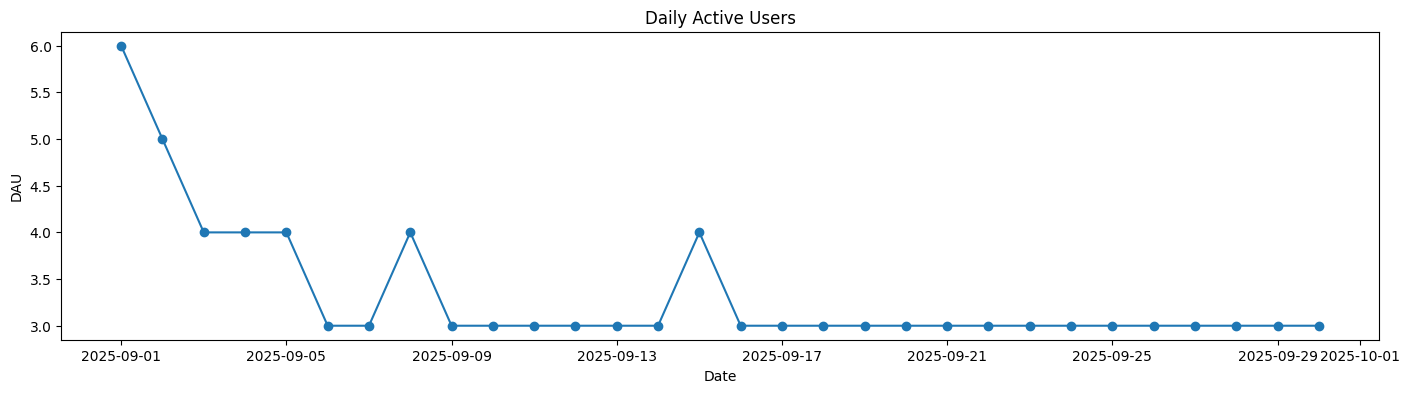

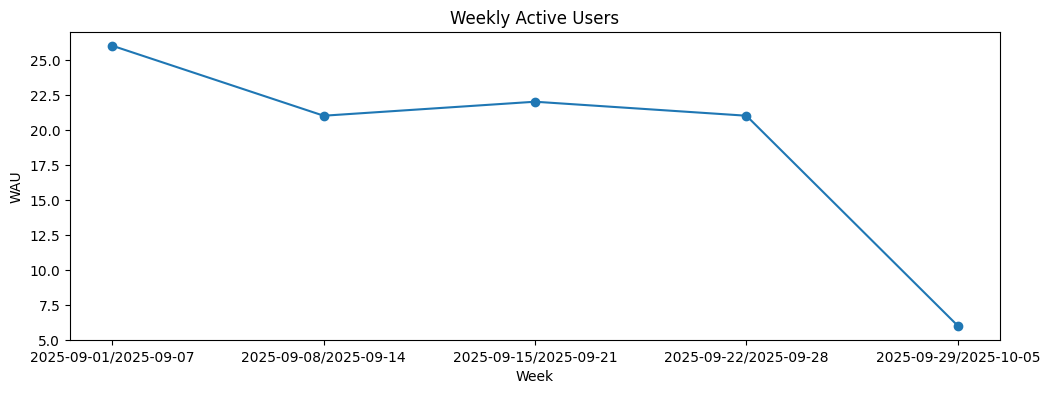

In [ ]:
# Convert to datetime
sessions['start_time'] = pd.to_datetime(sessions['start_time'])
sessions['date'] = sessions['start_time'].dt.date
sessions['week'] = sessions['start_time'].dt.to_period('W')

# DAU
dau = sessions.groupby('date')['user_id'].nunique().reset_index(name="DAU")
print("Daily Active Users:\n", dau)

# WAU
wau = sessions.groupby('week')['user_id'].nunique().reset_index(name="WAU")
print("\nWeekly Active Users:\n", wau)

# Plot
plt.figure(figsize=(17,4))
plt.plot(dau['date'], dau['DAU'], marker='o')
plt.title("Daily Active Users")
plt.xlabel("Date")
plt.ylabel("DAU")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(wau['week'].astype(str), wau['WAU'], marker='o')
plt.title("Weekly Active Users")
plt.xlabel("Week")
plt.ylabel("WAU")
plt.show()


2. Feature Adoption Rate

Feature Adoption Rates:
           feature_name  user_id  adoption_rate_%
0     AddPaymentMethod       13             26.0
1  CompleteTransaction       12             24.0
2        CreateAccount       28             56.0
3        SearchCatalog       41             82.0
4          ViewProfile        5             10.0


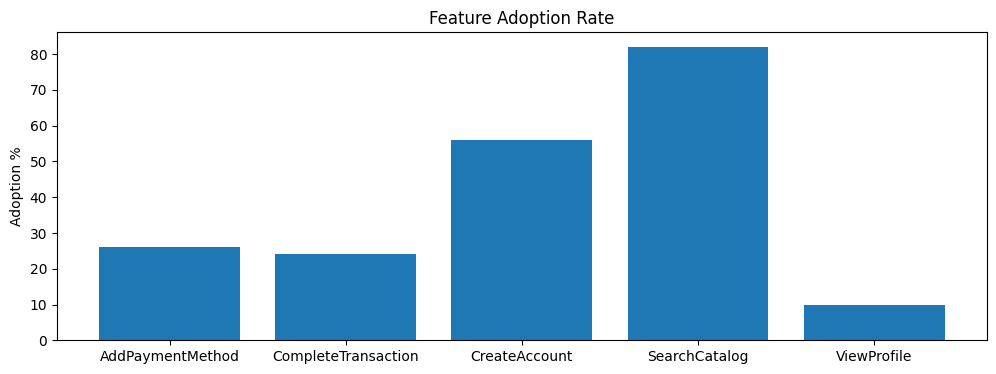

In [ ]:
# Total unique users
total_users = users['user_id'].nunique()

# Map session → user
feature_usage = feature_usage.merge(sessions[['session_id','user_id']], on='session_id', how='left')

# Adoption per feature
feature_adoption = feature_usage.groupby('feature_name')['user_id'].nunique().reset_index()
feature_adoption['adoption_rate_%'] = (feature_adoption['user_id'] / total_users) * 100

print("Feature Adoption Rates:\n", feature_adoption)

# Plot
plt.figure(figsize=(12,4))
plt.bar(feature_adoption['feature_name'], feature_adoption['adoption_rate_%'])
plt.title("Feature Adoption Rate")
plt.ylabel("Adoption %")
plt.show()


3. Retention Rate (Day 1, Day 7, Day 30)

Retention Rates (%): {'Day1': 2.083333333333333, 'Day7': 4.166666666666666, 'Day30': 0.0}


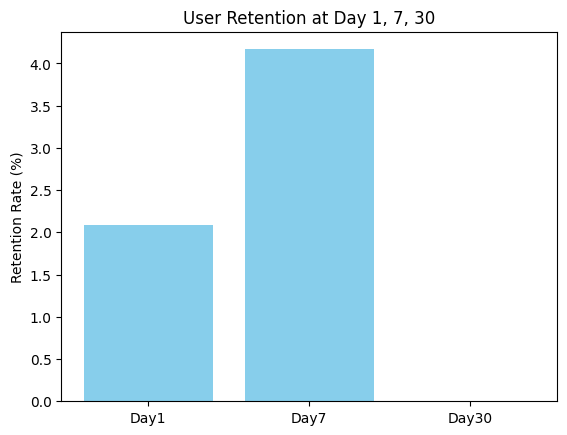

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sessions.csv
sessions = pd.read_csv("data/sessions.csv")

# Ensure datetime conversion
sessions['start_time'] = pd.to_datetime(sessions['start_time'])

# Add session_date column
sessions['session_date'] = sessions['start_time'].dt.date

# Step 1: Get each user's first session date
first_sessions = (
    sessions.groupby('user_id', as_index=False)['session_date']
    .min()
    .rename(columns={'session_date': 'first_date'})
)

# Step 2: Merge back (ensures no duplicate "first_date_x" issues)
sessions = pd.merge(
    sessions,
    first_sessions,
    on='user_id',
    how='left'
)

# Step 3: Calculate days since first session
sessions['days_since_first'] = (
    pd.to_datetime(sessions['session_date']) - pd.to_datetime(sessions['first_date'])
).dt.days

# Step 4: Retention calculation
total_users = sessions['user_id'].nunique()

retention = {
    "Day1": sessions[sessions['days_since_first'] == 1]['user_id'].nunique() / total_users * 100,
    "Day7": sessions[sessions['days_since_first'] == 7]['user_id'].nunique() / total_users * 100,
    "Day30": sessions[sessions['days_since_first'] == 30]['user_id'].nunique() / total_users * 100,
}

print("Retention Rates (%):", retention)

# Step 5: Plot Retention
plt.bar(retention.keys(), retention.values(), color='skyblue')
plt.ylabel("Retention Rate (%)")
plt.title("User Retention at Day 1, 7, 30")
plt.show()


4. Features Correlated with Repeat Sessions

In [ ]:
# Repeat users (users with >1 session)
repeat_users = sessions.groupby('user_id')['session_id'].count().reset_index()
repeat_users['repeat'] = repeat_users['session_id'] > 1

# User-feature counts
user_feature_counts = feature_usage.groupby(['user_id','feature_name']).size().unstack(fill_value=0)

# Merge repeat info with feature usage
user_repeat_data = repeat_users.merge(user_feature_counts, on='user_id', how='left').fillna(0)

# Drop non-numeric columns (like user_id) before correlation
numeric_data = user_repeat_data.drop(columns=['user_id'])

# Correlation with repeat usage
corr = numeric_data.corr()['repeat'].sort_values(ascending=False)
print("Feature correlation with repeat sessions:\n", corr)


Feature correlation with repeat sessions:
 repeat                 1.000000
session_id             0.768706
SearchCatalog          0.600211
CompleteTransaction    0.306186
AddPaymentMethod       0.236525
ViewProfile            0.227429
CreateAccount          0.173382
Name: repeat, dtype: float64


5. Behavioral Hypotheses Validation

In [ ]:
# Hypothesis 1: Tutorial users engage more
engaged = feature_usage.groupby('user_id')['feature_name'].apply(list).reset_index()
engaged['tutorial_used'] = engaged['feature_name'].apply(lambda x: 'Tutorial' in x)  # change if exact name differs
print("Tutorial vs Repeat Engagement:\n", pd.crosstab(engaged['tutorial_used'], repeat_users['repeat']))

# Hypothesis 2: Mobile users search more than desktop
mobile_users = sessions[sessions['device_type'] == 'Mobile']['user_id'].unique()
desktop_users = sessions[sessions['device_type'] == 'Desktop']['user_id'].unique()

search_users = feature_usage[feature_usage['feature_name'] == 'SearchCatalog']['user_id'].unique()
print("Search adoption - Mobile:", len(set(mobile_users) & set(search_users)))
print("Search adoption - Desktop:", len(set(desktop_users) & set(search_users)))

# Hypothesis 3: Feedback givers more engaged
feedback_users = feedback['user_id'].unique()
repeat_from_feedback = repeat_users[repeat_users['user_id'].isin(feedback_users)]
print("Avg sessions - Feedback Users:", repeat_from_feedback['session_id'].mean())
print("Avg sessions - All Users:", repeat_users['session_id'].mean())


Tutorial vs Repeat Engagement:
 repeat         False  True 
tutorial_used              
False             16     32
Search adoption - Mobile: 16
Search adoption - Desktop: 23
Avg sessions - Feedback Users: 2.142857142857143
Avg sessions - All Users: 2.0833333333333335


# **Part 2**: Product Funnel & Opportunity Identification

         Funnel Step  User Count  Conversion %
0   Account Creation          28        100.00
1     Payment Method          13         46.43
2  First Transaction          12         42.86


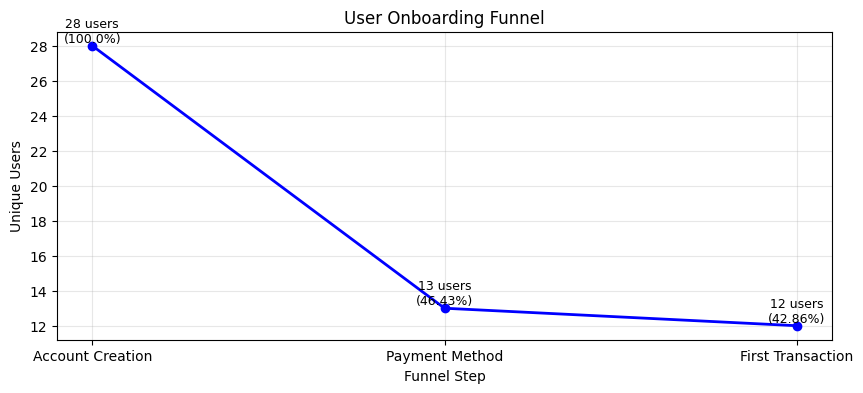

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Funnel steps mapping
funnel_steps = {
    "Account Creation": "CreateAccount",
    "Payment Method": "AddPaymentMethod",
    "First Transaction": "CompleteTransaction"
}

# Count distinct users at each step
funnel_counts = {}
base_users = set(feature_usage[feature_usage['feature_name'] == "CreateAccount"]["user_id"].unique())

for step, feat in funnel_steps.items():
    users = set(feature_usage[feature_usage['feature_name'] == feat]["user_id"].unique())
    funnel_counts[step] = len(users)

# Build dataframe
funnel_df = pd.DataFrame({
    "Funnel Step": list(funnel_counts.keys()),
    "User Count": list(funnel_counts.values())
})

# Conversion %
base = funnel_df.loc[0, "User Count"]
funnel_df["Conversion %"] = funnel_df["User Count"].apply(lambda x: round((x/base)*100, 2))

print(funnel_df)

# Funnel visualization
plt.figure(figsize=(10,4))
plt.plot(funnel_df["Funnel Step"], funnel_df["User Count"], marker='o', linewidth=2, color='blue')
for i, val in enumerate(funnel_df["User Count"]):
    plt.text(i, val+0.2, f"{val} users\n({funnel_df['Conversion %'][i]}%)", ha='center', fontsize=9)
plt.title("User Onboarding Funnel")
plt.xlabel("Funnel Step")
plt.ylabel("Unique Users")
plt.grid(alpha=0.3)
plt.show()
